# Setup

## Device

In [1]:
import torch

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


# Data preparation

## Load data

In [2]:
from data import load_data

train_path = './data/train_data.csv'
test_path = './data/test_data.csv'

X_train_all, y_train_all = load_data(train_path, target='SalePrice')
X_test, _ = load_data(test_path)

X_train_all.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Preprocess data

### Split data

In [3]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)

print("Size of training set: ", X_train.shape)
print("Size of validation set: ", X_val.shape)

Size of training set:  (3299, 16)
Size of validation set:  (825, 16)


### Categorical features

In [4]:
from data import one_hot_encode

categorical_cols = X_train_all.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    X_train = one_hot_encode(X_train, col)
    X_val = one_hot_encode(X_val, col)
    X_test = one_hot_encode(X_test, col)

X_train_all.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


### Standardize numerical features

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Upsample minority classes

In [6]:
from utils import price_to_class

class_distribution = y_train.apply(price_to_class).value_counts(normalize=True)
class_distribution

SalePrice
1    0.726887
2    0.140042
0    0.133071
Name: proportion, dtype: float64

In [7]:
# TODO: maybe use SMOTE?

### Datasets

In [8]:
class_weights = {c: (1 / v) for c, v in class_distribution.items()}
class_weights

{1: 1.3757297748123436, 2: 7.140692640692641, 0: 7.514806378132118}

In [9]:
from data import to_dataloader

train_loader = to_dataloader(X_train, y_train.values, class_weights=class_weights)
val_loader = to_dataloader(X_val, y_val.values)

In [10]:
vector_size = X_train.shape[1]

print("Vector size: ", vector_size)

Vector size:  33


# Model

In [11]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int = 1, dropout: float = 0.2):
        super().__init__()

        self.seq = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        return self.seq(x)

# Experiments

Epoch  1/50 - Train Loss: 153668.99 - Val Loss: 58751.67 - Val Acc: 0.7115 - LR: 0.001
Epoch  2/50 - Train Loss: 40477.40 - Val Loss: 44547.71 - Val Acc: 0.8242 - LR: 0.001
Epoch  3/50 - Train Loss: 38015.36 - Val Loss: 42633.64 - Val Acc: 0.8158 - LR: 0.001
Epoch  4/50 - Train Loss: 34885.99 - Val Loss: 41618.48 - Val Acc: 0.8267 - LR: 0.001
Epoch  5/50 - Train Loss: 34069.84 - Val Loss: 39385.09 - Val Acc: 0.8436 - LR: 0.001
Epoch  6/50 - Train Loss: 33715.48 - Val Loss: 38757.17 - Val Acc: 0.8291 - LR: 0.001
Epoch  7/50 - Train Loss: 34073.33 - Val Loss: 37443.48 - Val Acc: 0.8436 - LR: 0.001
Epoch  8/50 - Train Loss: 33058.37 - Val Loss: 36955.99 - Val Acc: 0.8388 - LR: 0.001
Epoch  9/50 - Train Loss: 33367.76 - Val Loss: 36242.94 - Val Acc: 0.8388 - LR: 0.001
Epoch 10/50 - Train Loss: 32562.41 - Val Loss: 36298.40 - Val Acc: 0.8570 - LR: 0.001
Epoch 11/50 - Train Loss: 31703.46 - Val Loss: 35803.58 - Val Acc: 0.8497 - LR: 0.001
Epoch 12/50 - Train Loss: 31890.50 - Val Loss: 36390.

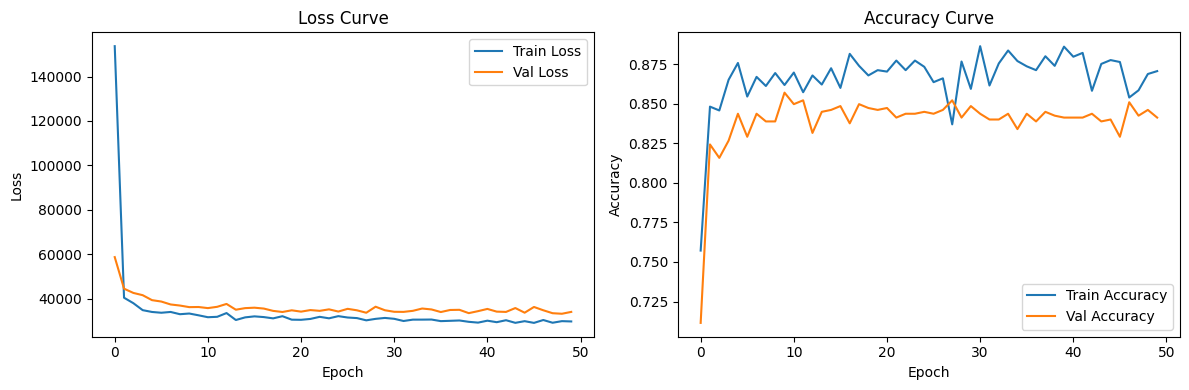

In [12]:
from train import Trainer

model = NeuralNetwork(input_size=vector_size).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

trainer = Trainer(model)
trainer.to_device(device)
trainer.compile(optimizer=optim, criterion=criterion)

trainer.fit(train_loader, val_loader, epochs=50)

# Evaluation

In [13]:
from train import predict

y_pred = predict(model, X_val, device)

### Accuracy per class

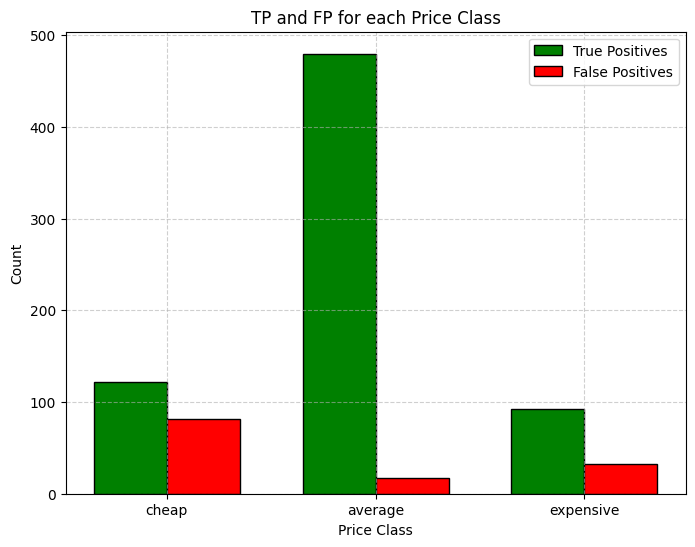

In [14]:
from plots import plot_pred_acc


plot_pred_acc(y_val, y_pred)

### Regression

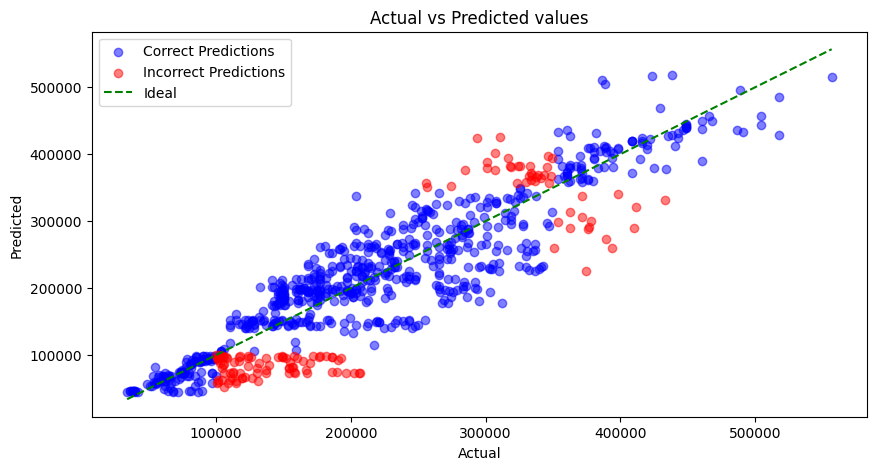

In [15]:
from plots import plot_regression

plot_regression(y_val, y_pred)